<a href="https://colab.research.google.com/github/arunangshudutta/DA6401_assignment_2/blob/main/Assignment_2_QA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 2/inaturalist_12K/train/'

In [ ]:
dataset_path = "inaturalist_12K/train/"

# Dataset

In [ ]:
!ls /content/drive/MyDrive/Colab\ Notebooks/DA6401/assignment\ 2/inaturalist_12K/train/

Amphibia  Arachnida  Fungi    Mammalia	Plantae
Animalia  Aves	     Insecta  Mollusca	Reptilia


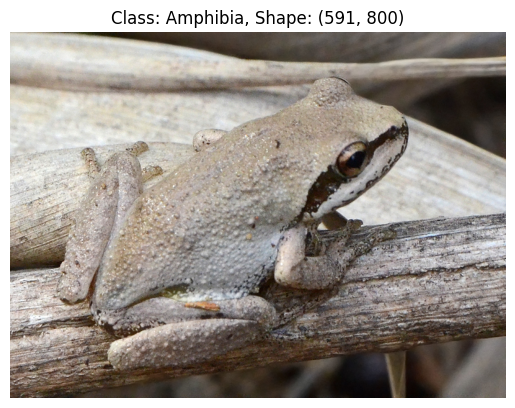

Class: Amphibia, Image shape (H, W): (591, 800)


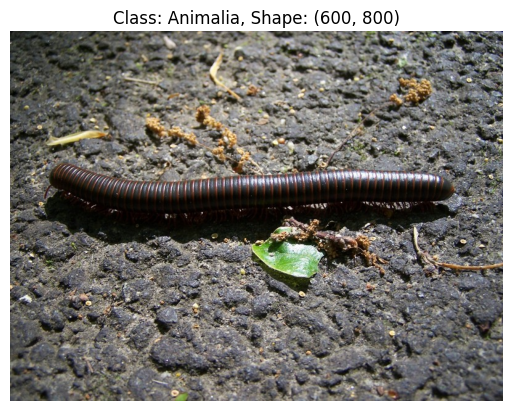

Class: Animalia, Image shape (H, W): (600, 800)


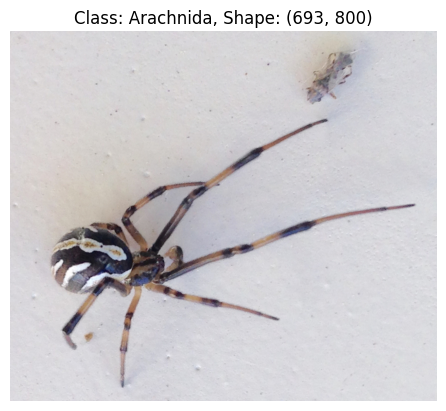

Class: Arachnida, Image shape (H, W): (693, 800)


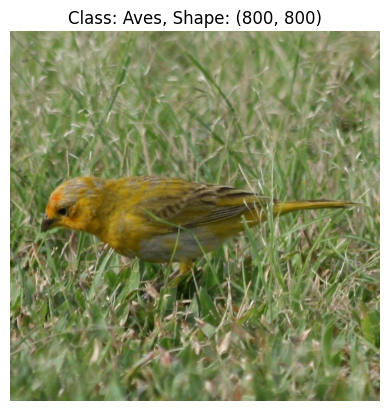

Class: Aves, Image shape (H, W): (800, 800)


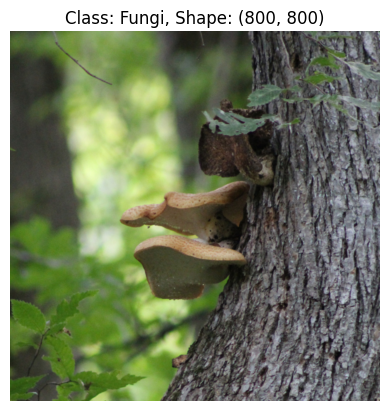

Class: Fungi, Image shape (H, W): (800, 800)


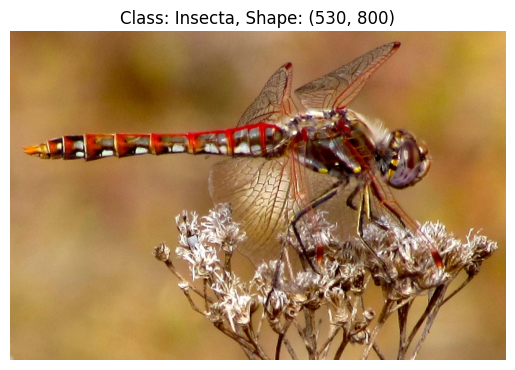

Class: Insecta, Image shape (H, W): (530, 800)


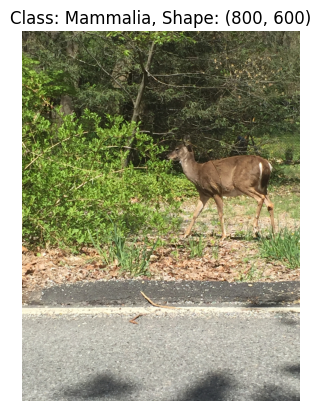

Class: Mammalia, Image shape (H, W): (800, 600)


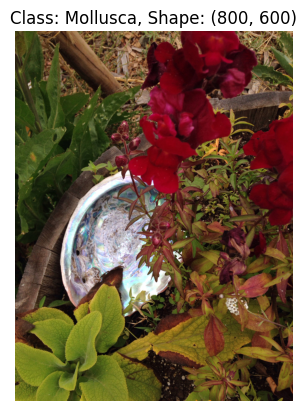

Class: Mollusca, Image shape (H, W): (800, 600)


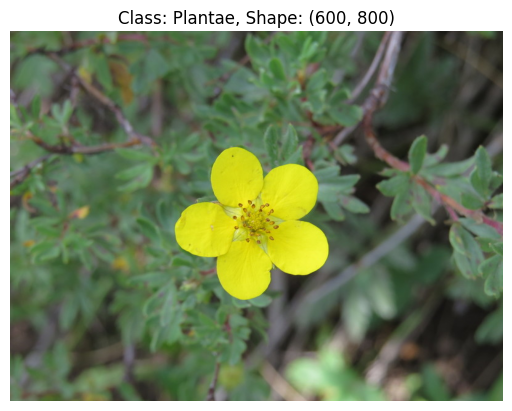

Class: Plantae, Image shape (H, W): (600, 800)


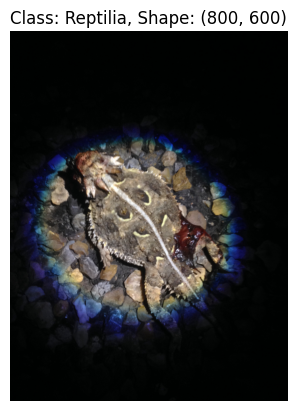

Class: Reptilia, Image shape (H, W): (800, 600)
Class list: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [ ]:
# Get all class folder names
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

# To store class names
class_list = []

# Display one image per class
for class_name in class_names:
    class_list.append(class_name)
    class_path = os.path.join(dataset_path, class_name)

    # Get one image file (you can filter by image extensions)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        image_path = os.path.join(class_path, image_files[0])
        image = Image.open(image_path)

        # Display image and shape
        plt.imshow(image)
        plt.title(f"Class: {class_name}, Shape: {image.size[::-1]}")
        plt.axis('off')
        plt.show()

        print(f"Class: {class_name}, Image shape (H, W): {image.size[::-1]}")
    else:
        print(f"No image found in class '{class_name}'")

# Optional: Print all class names
print("Class list:", class_list)

In [ ]:
# Get all class folder names
class_folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Count images per folder
for class_name in sorted(class_folders):
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Class '{class_name}': {len(image_files)} images")

Class 'Amphibia': 1000 images
Class 'Animalia': 1000 images
Class 'Arachnida': 1000 images
Class 'Aves': 1000 images
Class 'Fungi': 999 images
Class 'Insecta': 1000 images
Class 'Mammalia': 1000 images
Class 'Mollusca': 1000 images
Class 'Plantae': 1000 images
Class 'Reptilia': 1000 images


# Functions

In [ ]:
# ------------------------------
# Device setup for Colab
# ------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ------------------------------
# CNN Model Definition
# ------------------------------
class FlexibleCNN(nn.Module):
    def __init__(self,
                 in_channels=3,                           # Number of input channels (e.g., 3 for RGB)
                 conv_channels=[32, 64, 128, 256, 512],   # Number of filters in each conv layer
                 kernel_sizes=[3, 3, 3, 3, 3],            # Filter sizes for each conv layer
                 activation_fn=nn.ReLU(),                 # Activation function (flexible)
                 batch_norm=True,                         # Batch normalization flag
                 dense_size = 256,                       # Number of neurons in final dense layer
                 dropout_prob=0.3,                        # Dropout probability
                 num_classes=10,                          # Number of output classes
                 input_size=224):                         # Size of the input image (assumed square)

        super(FlexibleCNN, self).__init__()

        self.activation_fn = activation_fn
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_prob)

        layers = []
        current_in_channels = in_channels

        # Create convolutional blocks:
        # Conv -> BatchNorm -> Activation -> Pool -> Dropout
        for out_channels, kernel_size in zip(conv_channels, kernel_sizes):
            layers.append(nn.Conv2d(current_in_channels, out_channels,
                                    kernel_size=kernel_size, padding= kernel_size // 2))

            if batch_norm==True:
              layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization

            layers.append(activation_fn)                # Activation
            layers.append(self.pool)                    # Max pooling
            layers.append(nn.Dropout2d(dropout_prob))   # Spatial dropout
            current_in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        # Compute size after downsampling through pooling
        reduced_size = input_size // (2 ** len(conv_channels))  # Image is halved after each pool
        self.flatten_dim = current_in_channels * reduced_size * reduced_size

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, dense_size)      # Dense hidden layer
        self.activ_fc1 = activation_fn                        # Activation
        self.fc_dropout = nn.Dropout(dropout_prob)        # Dropout before output
        self.output = nn.Linear(dense_size, num_classes)         # Output layer

    def forward(self, x):
        x = self.conv_layers(x)             # Pass through conv blocks
        x = x.view(x.size(0), -1)           # Flatten
        x = self.fc1(x)                     # Fully connected hidden layer
        x = self.activ_fc1(x)               # activation
        x = self.fc_dropout(x)              # Dropout
        x = self.output(x)                  # Output logits
        return x

# ------------------------------
# Training Function
# ------------------------------
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()                   # Zero gradients
        outputs = model(inputs)                 # Forward pass
        loss = criterion(outputs, labels)       # Compute loss
        loss.backward()                         # Backward pass
        optimizer.step()                        # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)           # Get predicted class
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), correct / total


# ------------------------------
# Evaluation Function
# ------------------------------
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss_total += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss_total / len(loader), correct / total


# ------------------------------
# Dataloader
# ------------------------------
def load_split_dataset(dataset_path, train_ratio = 0.8, data_aug = False ,batch_size=64):

  if data_aug == True:
    transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
      transforms.ToTensor(),
      transforms.Normalize([0.5]*3, [0.5]*3)
    ])
  else:
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # resize to a common shape
        transforms.ToTensor(),          # convert image to PyTorch tensor
        transforms.Normalize([0.5]*3, [0.5]*3)  # normalize (assuming RGB images)
    ])


  full_train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

  # Set your train/val split ratio
  total_size = len(full_train_dataset)
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  # Split the dataset
  train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

  # Create DataLoaders
  train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

  # check counts
  print(f"Total images: {total_size}")
  print(f"Training images: {len(train_dataset)}")
  print(f"Validation images: {len(val_dataset)}")

  return train_loader, val_loader

Using device: cuda


# Training flow

In [ ]:
model = FlexibleCNN(
    in_channels=3,
    conv_channels=[32, 32, 32, 32, 32],
    kernel_sizes=[3, 3, 3, 3, 3],
    dense_size = 256,
    activation_fn=nn.ReLU(),
    dropout_prob=0.4,
    num_classes=10,
    input_size=224
).to(device)

print(model)

train_loader, val_loader = load_split_dataset(dataset_path, train_ratio = 0.8, data_aug = False, batch_size=64)

# ------------------------------
# Optimizer, Loss Function & LR Scheduler
# ------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)    # Adam optimizer
criterion = nn.CrossEntropyLoss()                              # Cross-entropy for classification


# ------------------------------
# Main Training Loop
# ------------------------------
epochs = 5
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc*100:.2f}%")

FlexibleCNN(
  (activation_fn): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.4, inplace=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.4, inplace=False)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Ma

Train Loss: 2.3170 | Train Accuracy: 12.66%
Val   Loss: 2.2857 | Val   Accuracy: 14.15%

Epoch 2/5


Train Loss: 2.2567 | Train Accuracy: 15.86%
Val   Loss: 2.2122 | Val   Accuracy: 16.00%

Epoch 3/5


Train Loss: 2.2287 | Train Accuracy: 17.14%
Val   Loss: 2.1867 | Val   Accuracy: 19.25%

Epoch 4/5


Train Loss: 2.2200 | Train Accuracy: 17.76%
Val   Loss: 2.1914 | Val   Accuracy: 20.05%

Epoch 5/5


Train Loss: 2.2013 | Train Accuracy: 18.18%
Val   Loss: 2.1568 | Val   Accuracy: 21.05%


# Wandb sweep

In [ ]:
import wandb

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'valid accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'num_filter': {
            'values': [16, 32, 64, 128]
        },
        'filter_org': {
            'values': ['same', 'double', 'half', 'type1', 'type2']
        },
        'batch_norm': {
            'values': ['yes', 'no']
        },
         'data_aug': {
            'values': ['yes', 'no']
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
         'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
         'activation': {
            'values': ['ReLU', 'GELU', 'SiLU', 'Mish']
        },
        'dense_size': {
            'values': [128, 256]
        },
    }
}
wandb.login(key="b81ae278300a216ce5380e07b52d628e2dd6eb69")
sweep_id = wandb.sweep(sweep = sweep_config, entity="arunangshudutta218-iitm", project = 'dl_assgn_2_q_A2_t1')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/student/.netrc
wandb: Currently logged in as: arunangshudutta218 (arunangshudutta218-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: oulk188d
Sweep URL: https://wandb.ai/arunangshudutta218-iitm/dl_assgn_2_q_A2_t1/sweeps/oulk188d


In [ ]:
def main():
  with wandb.init() as run:

    num_filter = wandb.config.num_filter
    filter_org = wandb.config.filter_org
    batch_norm = wandb.config.batch_norm
    data_aug = wandb.config.data_aug
    dropout = wandb.config.dropout
    learning_rate = wandb.config.learning_rate
    activation = wandb.config.activation
    dense_size = wandb.config.dense_size


    if filter_org == 'same':
      no_of_filters=[num_filter, num_filter, num_filter, num_filter, num_filter]
    elif filter_org=='double' :
      no_of_filters=[32,64,128,256,512]
    elif filter_org == 'half' :
      no_of_filters=[512,256,128,64,32]
    elif filter_org == 'type1' :
      no_of_filters=[16,32,32,64,64]
    elif filter_org == 'type2' :
      no_of_filters=[128,128,64,64,32]

    if activation == 'ReLU':
      act_func = nn.ReLU()
    elif activation == 'GELU':
      act_func = nn.GELU()
    elif activation == 'SiLU':
      act_func = nn.SiLU()
    elif activation == 'Mish':
      act_func = nn.Mish()

    if batch_norm == 'yes':
      batch_norm = True
    else:
      batch_norm = False

    if data_aug == 'yes':
      data_aug = True
    else:
      data_aug = False


    wandb.run.name = "f_{}_org_{}_norm_{}_aug_{}_drop_{}_lr_{}_ac_{}_ds_{}".format(num_filter, filter_org,
                                                                                      batch_norm, data_aug, dropout,
                                                                                      learning_rate, activation, dense_size)

    # ------------------------------
    # Dataloader
    # ------------------------------

    train_loader, val_loader = load_split_dataset(dataset_path, train_ratio = 0.8, data_aug = data_aug , batch_size=64)

    # ------------------------------
    # Model
    # ------------------------------

    model = FlexibleCNN(
        in_channels=3,
        conv_channels=no_of_filters,
        kernel_sizes=[3, 3, 3, 3, 3],
        dense_size = dense_size,
        activation_fn= act_func,
        batch_norm=batch_norm,
        dropout_prob= dropout,
        num_classes=10,
        input_size=224
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    # Adam optimizer
    criterion = nn.CrossEntropyLoss()                              # Cross-entropy for classification


    # ------------------------------
    # Main Training Loop
    # ------------------------------
    epochs = 20
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc*100:.2f}%")

        wandb.log({'tr_loss' : train_loss, 'tr_accuracy' : train_acc, 'val_loss' : val_loss, 'val_accuracy' : val_acc})




wandb.agent(sweep_id, function = main, count = 5)
wandb.finish()

wandb: Agent Starting Run: t2wt1sns with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: no
wandb: 	data_aug: no
wandb: 	dense_size: 128
wandb: 	dropout: 0.2
wandb: 	filter_org: half
wandb: 	learning_rate: 0.01
wandb: 	num_filter: 32


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/20


Training:   0%|                                                                                 | 0/125 [00:00<?, ?it/s]